# Problem Statement
## Background and Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

## Objective

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. It is necessary to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

# Import Data and Libraries

In [ ]:
# import necessary libraries

# data manipulation
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer

# neural network
import tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, InputLayer, Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD

# computer vision and images
import cv2
import PIL
from PIL import Image
from google.colab.patches import cv2_imshow
from cv2 import CV_64F

# Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# transfer learning
from keras.applications.vgg16 import VGG16

# model evaluation
from sklearn.metrics import confusion_matrix, classification_report, roc_curve

# pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# seeds
from tensorflow.keras import backend
import random
random.seed(1)
np.random.seed(1)
tensorflow.random.set_seed(1)

# warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import images
images = np.load('/content/drive/MyDrive/Project2_Plants/images.npy')

# import labels
labels = pd.read_csv('/content/drive/MyDrive/Project2_Plants/Labels.csv')

# Exploratory Data Analysis

## Memory and Datatype

In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [ ]:
# change "Label" to category
labels.Label = labels['Label'].astype('category')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Label   4750 non-null   category
dtypes: category(1)
memory usage: 5.2 KB


- "Label" variable is an object, that will be made into a category.
- By converting it into a category, we saved 32 kilobytes, as memory went from 37 KB to only 5 KB.

## Shape

In [ ]:
# shape of images
print(f'We have {images.shape[0]} images, each with a width of {images.shape[1]} and a height of {images.shape[2]}.')
print(f'Then we have {images.shape[3]} matrices for each image, representing the RGB color scheme.')

We have 4750 images, each with a width of 128 and a height of 128.
Then we have 3 matrices for each image, representing the RGB color scheme.


## Class Proportions

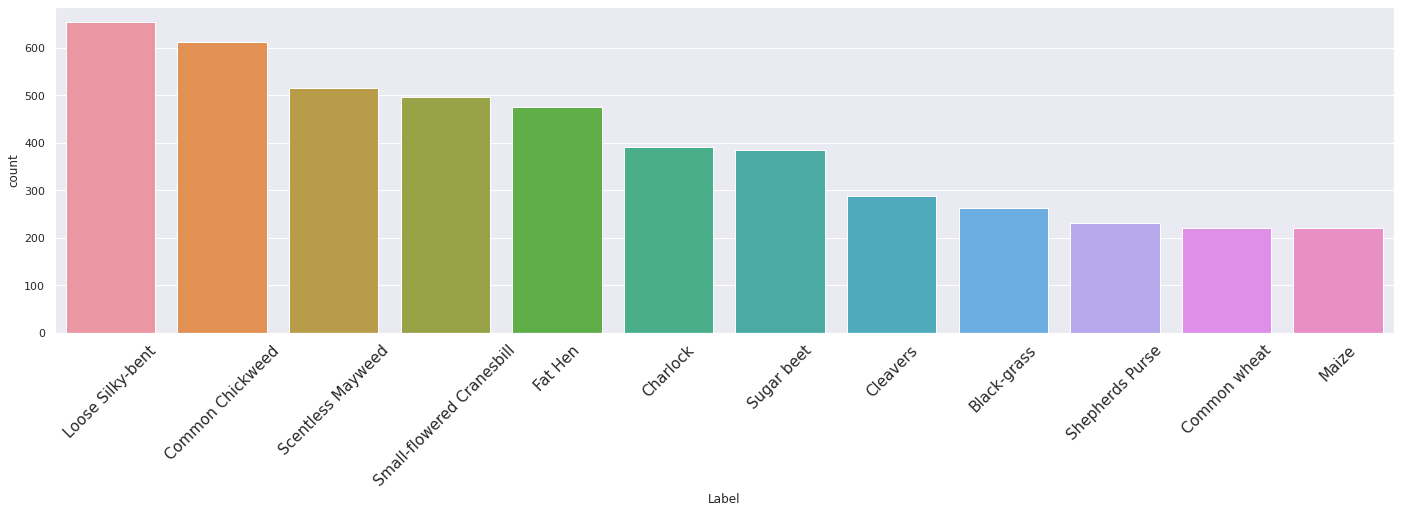

In [ ]:
plt.figure(figsize=(24,6))
sns.set(style='darkgrid')
sns.countplot(labels.Label, order=labels.Label.value_counts().index)
plt.xticks(fontsize=15, rotation=45)
plt.show()

In [ ]:
# class proportions
print('Count:')
print(labels.Label.value_counts())
print('')
print('Percentage:')
print(np.round(labels.Label.value_counts(1),4)*100)

Count:
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
Name: Label, dtype: int64

Percentage:
Loose Silky-bent             13.77
Common Chickweed             12.86
Scentless Mayweed            10.86
Small-flowered Cranesbill    10.44
Fat Hen                      10.00
Charlock                      8.21
Sugar beet                    8.11
Cleavers                      6.04
Black-grass                   5.54
Shepherds Purse               4.86
Common wheat                  4.65
Maize                         4.65
Name: Label, dtype: float64


- Insight:

The highest class is Loose Silky-bent, with 654 images while representing 13.77% of cases.
The lowest classes are Maize and Common wheat, each with 221 images and representing 4.65% of cases.

## Visualize Images

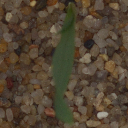

None


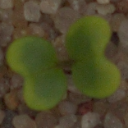

None


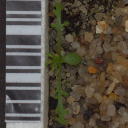

None


In [ ]:
# show 3 random images with cv2
print(cv2_imshow(images[1389]))
print(cv2_imshow(images[2084]))
print(cv2_imshow(images[3123]))

In [ ]:
# for loop to convert images to RGB color scheme
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

In [ ]:
# user defined function to plot several images
def plot_images(images, labels):
  num_classes=12
  categories = np.unique(labels)
  keys = dict(labels['Label'])
  rows=3
  cols=4
  fig = plt.figure(figsize=(10,8))

  for i in range(cols):
    for j in range(rows):
      random_index = np.random.randint(0, len(labels))
      ax = fig.add_subplot(rows, cols, i*rows + j + 1)
      ax.imshow(images[random_index, :])
      ax.set_title(keys[random_index])
  plt.show()

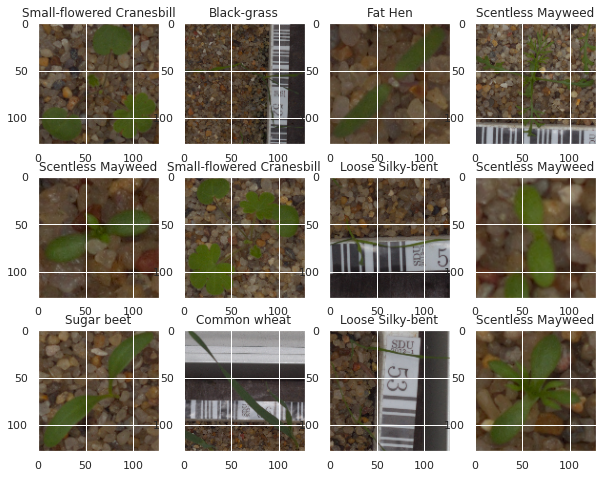

In [ ]:
# show images
plot_images(images, labels)

In [ ]:
# create series of class proportions with
label_counts = labels.Label.value_counts()

# create series of class proportions with percentages
label_counts_perc = labels.Label.value_counts(1)

print(f'On average every category has {np.round(label_counts.mean(),2)} images, that on average account for {np.round(label_counts_perc.mean(),4)*100}% of all images.')

On average every category has 395.83 images, that on average account for 8.33% of all images.


## Data Preprocessing

## Resize Images

In [ ]:
# decrease image size to 64x64
# use for loop and cv2.resize method, with interlinear interpolation
images_dec = []
h = 64
w = 64
dims = (h,w)
for i in range(len(images)):
  images_dec.append(cv2.resize(images[i], dims, interpolation = cv2.INTER_LINEAR))

## Gaussian Blurring

In [ ]:
# apply Gaussian Blurring
# use cv2 library for Gaussian Blur
images_gb = []
for i in range(len(images)):
  images_gb.append(cv2.GaussianBlur(images[i], ksize=(3,3), sigmaX=0))

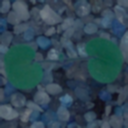

In [ ]:
# see blurred image
cv2_imshow(images_gb[0])

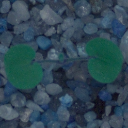

In [ ]:
# see normal image
cv2_imshow(images[0])

In [ ]:
# apply Gaussian Blurring to decreased images
images_dec_gb = []
for i in range(len(images_dec)):
  images_dec_gb.append(cv2.GaussianBlur(images_dec[i], ksize=(3,3), sigmaX=0))

## Data Split

In [ ]:
# normal data split
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images),labels , test_size=0.1, random_state=42,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
print('Training set shape:', (X_train.shape, y_train.shape))
print('Training set shape:', (X_val.shape, y_val.shape))
print('Test set shape:', (X_test.shape, y_test.shape))

Training set shape: ((3847, 128, 128, 3), (3847, 1))
Training set shape: ((428, 128, 128, 3), (428, 1))
Test set shape: ((475, 128, 128, 3), (475, 1))


- Three other splits will be made, one for the resized images, another for the blurred ones and a final one for both blurred and resized images.

In [ ]:
# data split for resized images
X_temp, X_test_dec, y_temp, y_test_dec = train_test_split(np.array(images_dec),labels , test_size=0.1, random_state=42,stratify=labels)
X_train_dec, X_val_dec, y_train_dec, y_val_dec = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
# data split for blurred images
X_temp, X_test_gb, y_temp, y_test_gb = train_test_split(np.array(images_gb),labels , test_size=0.1, random_state=42,stratify=labels)
X_train_gb, X_val_gb, y_train_gb, y_val_gb = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

In [ ]:
# data split for blurred and resized images
X_temp, X_test_dec_gb, y_temp, y_test_dec_gb = train_test_split(np.array(images_dec_gb),labels , test_size=0.1, random_state=42,stratify=labels)
X_train_dec_gb, X_val_dec_gb, y_train_dec_gb, y_val_dec_gb = train_test_split(X_temp,y_temp , test_size=0.1, random_state=42,stratify=y_temp)

## One Hot Encoding

In [ ]:
# one hot encode target variable
enc = LabelBinarizer()
y_train_enc = enc.fit_transform(y_train)
y_val_enc =enc.transform(y_val)
y_test_enc =enc.transform(y_test)

# one hot encode target variable for decreased images
y_train_dec_enc = enc.fit_transform(y_train_dec)
y_val_dec_enc =enc.transform(y_val_dec)
y_test_dec_enc =enc.transform(y_test_dec)

# one hot encode target variable for blurred images
y_train_gb_enc = enc.fit_transform(y_train_gb)
y_val_gb_enc =enc.transform(y_val_gb)
y_test_gb_enc =enc.transform(y_test_gb)

# one hot encode target variable for blurred and resized images
y_train_dec_gb_enc = enc.fit_transform(y_train_dec_gb)
y_val_dec_gb_enc =enc.transform(y_val_dec_gb)
y_test_dec_gb_enc =enc.transform(y_test_dec_gb)

## Data Normalization

In [ ]:
# normalize X
X_train_norm = X_train.astype('float32')/255.0
X_val_norm = X_val.astype('float32')/255.0
X_test_norm = X_test.astype('float32')/255.0

# normalize X for decreased images
X_train_dec_norm = X_train_dec.astype('float32')/255.0
X_val_dec_norm = X_val_dec.astype('float32')/255.0
X_test_dec_norm = X_test_dec.astype('float32')/255.0

# normalize X for blurred images
X_train_gb_norm = X_train_gb.astype('float32')/255.0
X_val_gb_norm = X_val_gb.astype('float32')/255.0
X_test_gb_norm = X_test_gb.astype('float32')/255.0

# normalize X for blurred and decreased images
X_train_dec_gb_norm = X_train_dec_gb.astype('float32')/255.0
X_val_dec_gb_norm = X_val_dec_gb.astype('float32')/255.0
X_test_dec_gb_norm = X_test_dec_gb.astype('float32')/255.0

# Building CNNs

## Model 1
We will start with a very simple model to use it as a baseline and add more complexity and modifications moving forward.

**Architecture:**
- Data used: Normal images
- Sequential
- Convolution layer with 64 3x3 filters and padding=same
- Max Pooling layer with 2x2 filters and padding=same
- Flattening layer
- Dense layer with 64 neurons
- Batch Normalization
- Dense layer with 32 neurons
- Batch Normalization
- Dense layer with 16 neurons
- Dense layer with 12 outputs and softmax activation
- Optimizer = Adam
- Loss = Categorical Crossentropy
- Metric = Accuracy
- Epochs = 30
- Batch Size = 48

In [ ]:
# clear backend
backend.clear_session()

# set random seed
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# build CNN
model1 = Sequential()
model1.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(128,128,3)))
model1.add(MaxPooling2D((2,2), padding='same'))
model1.add(Flatten())

# fully connected layers
model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.30))
model1.add(BatchNormalization())
model1.add(Dense(32, activation='relu'))
model1.add(Dropout(0.30))
model1.add(BatchNormalization())
model1.add(Dense(16, activation='relu'))
model1.add(Dense(12, activation='softmax'))

# compile model
model1.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# model summary
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 64)                16777280  
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                          

In [ ]:
# fit data to model
history1 = model1.fit(X_train_norm, y_train_enc,
                      epochs=30,
                      validation_data=(X_val_norm, y_val_enc),
                      batch_size=48,
                      verbose=2
                      )

Epoch 1/30
81/81 - 15s - loss: 2.6214 - accuracy: 0.0936 - val_loss: 2.4258 - val_accuracy: 0.2313 - 15s/epoch - 190ms/step
Epoch 2/30
81/81 - 2s - loss: 2.4468 - accuracy: 0.1401 - val_loss: 2.3626 - val_accuracy: 0.1285 - 2s/epoch - 28ms/step
Epoch 3/30
81/81 - 2s - loss: 2.1817 - accuracy: 0.2607 - val_loss: 2.3197 - val_accuracy: 0.2664 - 2s/epoch - 28ms/step
Epoch 4/30
81/81 - 2s - loss: 1.9546 - accuracy: 0.3494 - val_loss: 2.0896 - val_accuracy: 0.2477 - 2s/epoch - 27ms/step
Epoch 5/30
81/81 - 2s - loss: 1.7607 - accuracy: 0.4068 - val_loss: 1.9604 - val_accuracy: 0.2687 - 2s/epoch - 27ms/step
Epoch 6/30
81/81 - 2s - loss: 1.5826 - accuracy: 0.4523 - val_loss: 1.7179 - val_accuracy: 0.3995 - 2s/epoch - 27ms/step
Epoch 7/30
81/81 - 2s - loss: 1.4880 - accuracy: 0.4900 - val_loss: 1.7927 - val_accuracy: 0.4136 - 2s/epoch - 27ms/step
Epoch 8/30
81/81 - 2s - loss: 1.4125 - accuracy: 0.5082 - val_loss: 1.5107 - val_accuracy: 0.5070 - 2s/epoch - 27ms/step
Epoch 9/30
81/81 - 2s - loss:

### Model 1 Performance

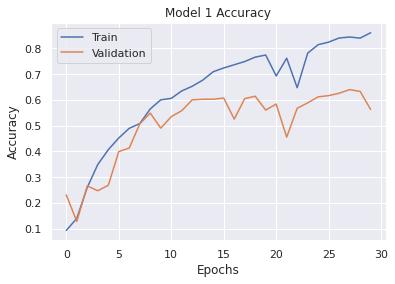

In [ ]:
# plot model performance
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])

plt.title('Model 1 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [ ]:
accuracy1 = model1.evaluate(X_test_norm, y_test_enc, verbose=2)

15/15 - 0s - loss: 1.4899 - accuracy: 0.6189 - 333ms/epoch - 22ms/step


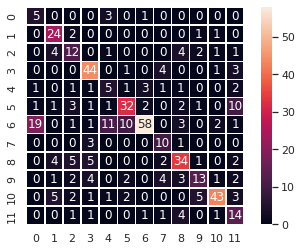

In [ ]:
y_pred = model1.predict(X_test_norm)

y_pred_max = np.argmax(y_pred, axis=1)
y_test_max = np.argmax(y_test_enc, axis=1)

cm = tf.math.confusion_matrix(y_pred_max, y_test_max)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            linewidth=0.4,
            square=True)

In [ ]:
cf1 = classification_report(y_pred_max, y_test_max)
print(cf1)

              precision    recall  f1-score   support

           0       0.19      0.56      0.29         9
           1       0.62      0.86      0.72        28
           2       0.41      0.48      0.44        25
           3       0.72      0.83      0.77        53
           4       0.23      0.31      0.26        16
           5       0.67      0.59      0.63        54
           6       0.89      0.55      0.68       106
           7       0.45      0.71      0.56        14
           8       0.65      0.64      0.65        53
           9       0.57      0.41      0.47        32
          10       0.86      0.69      0.77        62
          11       0.37      0.61      0.46        23

    accuracy                           0.62       475
   macro avg       0.55      0.60      0.56       475
weighted avg       0.68      0.62      0.63       475



### Model 1 Insights
- It does not seem to overfit and has OK test accuracy (61%)
- The model had trouble recognizing classes 0,2,4,9 and 11, while it had the most success identifying classes 1, 3, 6 and 10.


## Model 2
This model is the same as Model 1, but resized images will be used. This is to see if resizing has an impact on performance.

**Architecture:**
- Data used: Resized images
- Sequential
- Convolution layer with 64 3x3 filters and padding=same
- Max Pooling layer with 2x2 filters and padding=same
- Flattening layer
- Dense layer with 64 neurons and relu activation
- Batch Normalization
- Dense layer with 32 neurons and relu activation
- Batch Normalization
- Dense layer with 16 neurons and relu activation
- Dense layer with 12 outputs and softmax activation
- Optimizer = Adam
- Loss = Categorical Crossentropy
- Metric = Accuracy
- Epochs = 30
- Batch Size = 48

In [ ]:
# clear backend
backend.clear_session()

# set random seed
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# build CNN
model2 = Sequential()
model2.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3))) # chance input to 64x64
model2.add(MaxPooling2D((2,2), padding='same'))
model2.add(Flatten())

# fully connected layers
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.30))
model2.add(BatchNormalization())
model2.add(Dense(32, activation='relu'))
model2.add(Dropout(0.30))
model2.add(BatchNormalization())
model2.add(Dense(16, activation='relu'))
model2.add(Dense(12, activation='softmax'))

# compile model
model2.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# model summary
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dense (Dense)               (None, 64)                4194368   
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               256       
 ormalization)                                          

In [ ]:
# fit data to model
history2 = model2.fit(X_train_dec_norm, y_train_dec_enc,
                      epochs=30,
                      validation_data=(X_val_dec_norm, y_val_dec_enc),
                      batch_size=48,
                      verbose=2
                      )

Epoch 1/30
81/81 - 1s - loss: 1.4979 - accuracy: 0.4786 - val_loss: 1.4624 - val_accuracy: 0.5000 - 843ms/epoch - 10ms/step
Epoch 2/30
81/81 - 1s - loss: 1.4066 - accuracy: 0.5038 - val_loss: 1.3383 - val_accuracy: 0.5467 - 706ms/epoch - 9ms/step
Epoch 3/30
81/81 - 1s - loss: 1.2864 - accuracy: 0.5506 - val_loss: 1.2744 - val_accuracy: 0.5701 - 715ms/epoch - 9ms/step
Epoch 4/30
81/81 - 1s - loss: 1.2860 - accuracy: 0.5539 - val_loss: 1.2569 - val_accuracy: 0.5678 - 714ms/epoch - 9ms/step
Epoch 5/30
81/81 - 1s - loss: 1.1958 - accuracy: 0.5815 - val_loss: 1.2014 - val_accuracy: 0.5958 - 714ms/epoch - 9ms/step
Epoch 6/30
81/81 - 1s - loss: 1.1387 - accuracy: 0.5960 - val_loss: 1.2183 - val_accuracy: 0.5841 - 703ms/epoch - 9ms/step
Epoch 7/30
81/81 - 1s - loss: 1.0728 - accuracy: 0.6270 - val_loss: 1.2136 - val_accuracy: 0.5701 - 794ms/epoch - 10ms/step
Epoch 8/30
81/81 - 1s - loss: 1.0431 - accuracy: 0.6324 - val_loss: 1.2798 - val_accuracy: 0.5911 - 700ms/epoch - 9ms/step
Epoch 9/30
81/

### Model 2 Performance

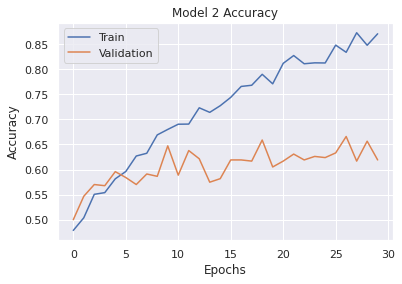

In [ ]:
# plot model performance
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.title('Model 2 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [ ]:
accuracy2 = model2.evaluate(X_test_dec_norm, y_test_dec_enc, verbose=2)

15/15 - 0s - loss: 1.1971 - accuracy: 0.6442 - 114ms/epoch - 8ms/step


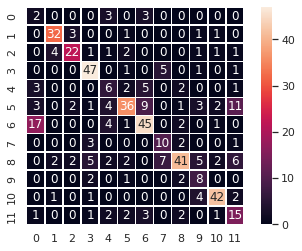

In [ ]:
y_pred = model2.predict(X_test_dec_norm)

y_pred_max = np.argmax(y_pred, axis=1)
y_test_max = np.argmax(y_test_dec_enc, axis=1)

cm = tf.math.confusion_matrix(y_pred_max, y_test_max)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            linewidth=0.4,
            square=True)

In [ ]:
cf2 = classification_report(y_pred_max, y_test_max)
print(cf2)

              precision    recall  f1-score   support

           0       0.08      0.25      0.12         8
           1       0.82      0.84      0.83        38
           2       0.76      0.67      0.71        33
           3       0.77      0.85      0.81        55
           4       0.27      0.32      0.29        19
           5       0.75      0.50      0.60        72
           6       0.69      0.64      0.67        70
           7       0.45      0.62      0.53        16
           8       0.79      0.55      0.65        74
           9       0.35      0.62      0.44        13
          10       0.84      0.84      0.84        50
          11       0.39      0.56      0.46        27

    accuracy                           0.64       475
   macro avg       0.58      0.61      0.58       475
weighted avg       0.69      0.64      0.66       475



### Model 2 Insights
- Although the model has better test accuracy (64%) it overfits
- As Model 1, it had trouble recognizing classes 1, 4, 9 and 11, and succeeded in identifying classes 1, 3 and 10 with better accuracy

## Model 3
Model 3 will have the same architecture as Models 1 and 2, the difference is that Gaussian Blurred images will be used. We will see which dataset performs better and based on that decide which dataset to use moving on. Resized images will be used as they had a slightly better accuracy than normal sized images.

**Architecture:**

- Data used: Gaussian Blurred Images
- Sequential
- Convolution layer with 64 3x3 filters and padding=same
- Max Pooling layer with 2x2 filters and padding=same
- Flattening layer
- Dense layer with 64 neurons
- Batch Normalization
- Dense layer with 32 neurons
- Batch Normalization
- Dense layer with 16 neurons
- Dense layer with 12 outputs and softmax activation
- Optimizer = Adam
- Loss = Categorical Crossentropy
- Metric = Accuracy
- Epochs = 30
- Batch Size = 48

In [ ]:
# clear backend
backend.clear_session()

# set random seed
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [ ]:
# build CNN
model3 = Sequential()
model3.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model3.add(MaxPooling2D((2,2), padding='same'))
model3.add(Flatten())

# fully connected layers
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(0.30))
model3.add(BatchNormalization())
model3.add(Dense(32, activation='relu'))
model3.add(Dropout(0.30))
model3.add(BatchNormalization())
model3.add(Dense(16, activation='relu'))
model3.add(Dense(12, activation='softmax'))

# compile model
model3.compile(optimizer = Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# model summary
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 65536)             0         
                                                                 
 dense_4 (Dense)             (None, 64)                4194368   
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                      

In [ ]:
# fit data to model
history3 = model3.fit(X_train_dec_gb_norm, y_train_dec_gb_enc,
                      epochs=30,
                      validation_data=(X_val_dec_gb_norm, y_val_gb_enc),
                      batch_size=48,
                      verbose=2
                      )

Epoch 1/30
81/81 - 3s - loss: 2.6972 - accuracy: 0.0938 - val_loss: 2.5168 - val_accuracy: 0.1005 - 3s/epoch - 33ms/step
Epoch 2/30
81/81 - 1s - loss: 2.3262 - accuracy: 0.2126 - val_loss: 2.4662 - val_accuracy: 0.1285 - 893ms/epoch - 11ms/step
Epoch 3/30
81/81 - 1s - loss: 1.9884 - accuracy: 0.3657 - val_loss: 2.3483 - val_accuracy: 0.2009 - 758ms/epoch - 9ms/step
Epoch 4/30
81/81 - 1s - loss: 1.7203 - accuracy: 0.4541 - val_loss: 2.1053 - val_accuracy: 0.2383 - 700ms/epoch - 9ms/step
Epoch 5/30
81/81 - 1s - loss: 1.5534 - accuracy: 0.4965 - val_loss: 1.7910 - val_accuracy: 0.3481 - 706ms/epoch - 9ms/step
Epoch 6/30
81/81 - 1s - loss: 1.4062 - accuracy: 0.5321 - val_loss: 1.5007 - val_accuracy: 0.5257 - 699ms/epoch - 9ms/step
Epoch 7/30
81/81 - 1s - loss: 1.3286 - accuracy: 0.5516 - val_loss: 1.3348 - val_accuracy: 0.5771 - 709ms/epoch - 9ms/step
Epoch 8/30
81/81 - 1s - loss: 1.2423 - accuracy: 0.5888 - val_loss: 1.1792 - val_accuracy: 0.6355 - 721ms/epoch - 9ms/step
Epoch 9/30
81/81 

### Model 3 Performance

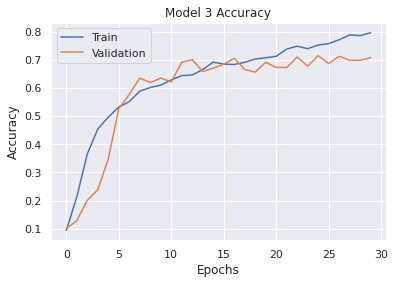

In [ ]:
# plot model performance
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])

plt.title('Model 3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [ ]:
accuracy3 = model3.evaluate(X_test_dec_gb_norm, y_test_dec_gb_enc, verbose=2)

15/15 - 0s - loss: 0.8871 - accuracy: 0.7200 - 78ms/epoch - 5ms/step


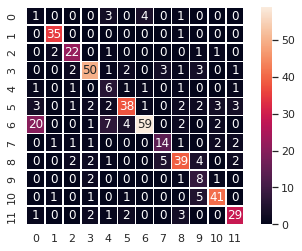

In [ ]:
y_pred = model3.predict(X_test_dec_gb_norm)

y_pred_max = np.argmax(y_pred, axis=1)
y_test_max = np.argmax(y_test_dec_gb_enc, axis=1)

cm = tf.math.confusion_matrix(y_pred_max, y_test_max)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            linewidth=0.4,
            square=True)

In [ ]:
cf3 = classification_report(y_pred_max, y_test_max)
print(cf3)

              precision    recall  f1-score   support

           0       0.04      0.11      0.06         9
           1       0.90      0.97      0.93        36
           2       0.76      0.81      0.79        27
           3       0.82      0.79      0.81        63
           4       0.27      0.50      0.35        12
           5       0.79      0.67      0.72        57
           6       0.91      0.62      0.74        95
           7       0.64      0.64      0.64        22
           8       0.75      0.71      0.73        55
           9       0.35      0.67      0.46        12
          10       0.82      0.84      0.83        49
          11       0.76      0.76      0.76        38

    accuracy                           0.72       475
   macro avg       0.65      0.67      0.65       475
weighted avg       0.77      0.72      0.74       475



### Model 3 Insights
- Model seems to be in a parfect spot as it does not overfit and improved test accuracy by 8 points (72%)
- It performed better overall, but still had trouble recognizing classes 0, 4 and 9, but as mentioned before accuracy in every other category improved.


## Model 4

In Model 4 we will add some more complexity, as we will add a few more convolution, pooling and normalization layers. We will use the blurred and resized data as it had the highest test accuracy.

**Architecture:**
- Data used: Blurred & Resized images
- Sequential
- Convolution layer with 64 3x3 filters and padding=same
- Max Pooling layer with 2x2 filters and padding=same
- Batch Normalization
- Convolution layer with 32 3x3 filters and padding=same
- Max Pooling layer with 2x2 filters and padding=same
- Batch Normalization
- Convolution layer with 16 3x3 filters and padding=same
- Max Pooling layer with 2x2 filters and padding=same
- Batch Normalization
- Flattening layer
- Dense layer with 64 neurons
- Dropout 30%
- Batch Normalization
- Dense layer with 32 neurons
- Dropout 30%
- Batch Normalization
- Dense layer with 16 neurons
- Dense layer with 12 outputs and softmax activation
- Optimizer = Adam
- Loss = Categorical Crossentropy
- Metric = Accuracy
- Epochs = 30
- Batch Size = 48

In [ ]:
# build CNN
model4 = Sequential()

model4.add(Conv2D(64, (3,3), activation='relu', padding='same', input_shape=(64,64,3)))
model4.add(MaxPooling2D((2,2), padding='same'))
model4.add(BatchNormalization())

model4.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model4.add(MaxPooling2D((2,2), padding='same'))
model4.add(BatchNormalization())

model4.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model4.add(MaxPooling2D((2,2), padding='same'))
model4.add(BatchNormalization())

model4.add(Flatten())

model4.add(Dense(64, activation='relu'))
model4.add
model4.add(BatchNormalization())
model4.add(Dense(32, activation='relu'))
model4.add(BatchNormalization())
model4.add(Dense(16, activation='relu'))

model4.add(Dense(12, activation='softmax'))

# compile model
model4.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics = ['accuracy'])
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_14 (Bat  (None, 32, 32, 64)       256       
 chNormalization)                                                
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                      

In [ ]:
history4 = model4.fit(X_train_dec_gb_norm, y_train_dec_gb_enc,
                      epochs=30,
                      batch_size=48,
                      validation_data=(X_val_dec_gb_norm, y_val_dec_gb_enc),
                      verbose=2)

Epoch 1/30
81/81 - 3s - loss: 2.0866 - accuracy: 0.3228 - val_loss: 2.7510 - val_accuracy: 0.1379 - 3s/epoch - 32ms/step
Epoch 2/30
81/81 - 1s - loss: 1.4021 - accuracy: 0.5448 - val_loss: 3.1784 - val_accuracy: 0.1379 - 822ms/epoch - 10ms/step
Epoch 3/30
81/81 - 1s - loss: 1.0593 - accuracy: 0.6587 - val_loss: 3.5328 - val_accuracy: 0.1355 - 823ms/epoch - 10ms/step
Epoch 4/30
81/81 - 1s - loss: 0.8413 - accuracy: 0.7362 - val_loss: 3.1167 - val_accuracy: 0.1659 - 864ms/epoch - 11ms/step
Epoch 5/30
81/81 - 1s - loss: 0.6957 - accuracy: 0.7788 - val_loss: 2.7516 - val_accuracy: 0.2150 - 1s/epoch - 16ms/step
Epoch 6/30
81/81 - 1s - loss: 0.5511 - accuracy: 0.8292 - val_loss: 2.4895 - val_accuracy: 0.2944 - 920ms/epoch - 11ms/step
Epoch 7/30
81/81 - 1s - loss: 0.4688 - accuracy: 0.8544 - val_loss: 1.3319 - val_accuracy: 0.5607 - 1s/epoch - 14ms/step
Epoch 8/30
81/81 - 1s - loss: 0.3744 - accuracy: 0.8851 - val_loss: 1.2656 - val_accuracy: 0.6379 - 977ms/epoch - 12ms/step
Epoch 9/30
81/81 

### Model 4 Performance

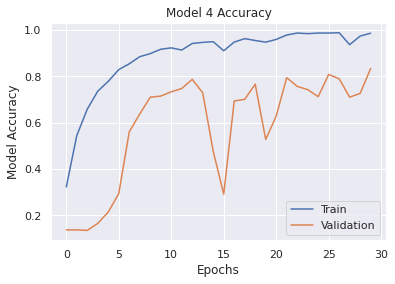

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])

plt.title('Model 4 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Model Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [ ]:
accuracy4 = model4.evaluate(X_test_dec_gb_norm, y_test_dec_gb_enc, verbose=2)

15/15 - 0s - loss: 0.9322 - accuracy: 0.7853 - 345ms/epoch - 23ms/step


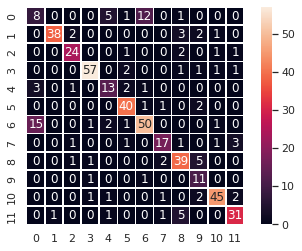

In [ ]:
y_pred = model4.predict(X_test_dec_gb_norm)

y_pred_max = np.argmax(y_pred, axis=1)
y_test_max = np.argmax(y_test_dec_gb_enc, axis=1)

cm = tf.math.confusion_matrix(y_pred_max, y_test_max)

sns.heatmap(cm,
            annot=True,
            fmt='d',
            linewidth=0.4,
            square=True)

In [ ]:
cf4 = classification_report(y_pred_max, y_test_max)
print(cf4)

              precision    recall  f1-score   support

           0       0.31      0.30      0.30        27
           1       0.97      0.83      0.89        46
           2       0.83      0.83      0.83        29
           3       0.93      0.90      0.92        63
           4       0.59      0.65      0.62        20
           5       0.83      0.91      0.87        44
           6       0.77      0.71      0.74        70
           7       0.77      0.71      0.74        24
           8       0.75      0.81      0.78        48
           9       0.48      0.85      0.61        13
          10       0.90      0.87      0.88        52
          11       0.82      0.79      0.81        39

    accuracy                           0.79       475
   macro avg       0.75      0.76      0.75       475
weighted avg       0.80      0.79      0.79       475



### Model 4 Insights
- The learning curve looks irregular as it has many peaks, and the model overfits a little
- It is our best model until now, as we achieved highest test accuracy (78.5%) and have very good scores for every class except 0

## Model 5: Transfer Learning
In this model we will introduce the Transfer Learning concept, which uses weights and features from other trained models and applies them to your task. We will use the VGG16 model for feature extraction and continue to train our weights with Dense layers for prediction purposes.

**Architecture:**
- Sequential
- VGG16
- Dense layer with 64 neurons and relu activation
- Dropout 30%
- Batch Normalization
- Dense layer with 32 neurons and relu activation
- Dropout 30%
- Batch Normalization
- Dense layer with 16 neurons and relu activation
- Dense layer with 12 outputs and softmax activation
- Optimizer = Adam
- Loss = Categorical Crossentropy
- Metric = Accuracy
- Epochs = 25
- Batch Size = 32

In [ ]:
# import vgg model
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

# make vgg layers non-trainable (freeze)
for layer in vgg.layers:
  layer.trainable=False
vgg.summary()

58900480/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
# build sequential CNN with VGG
model5 = Sequential()
model5.add(vgg)
model5.add(Flatten())

# build fully connected layers
model5.add(Dense(64, activation='relu'))
model5.add
model5.add(BatchNormalization())
model5.add(Dense(32, activation='relu'))
model5.add(BatchNormalization())
model5.add(Dense(16, activation='relu'))

model5.add(Dense(12, activation='softmax'))

model5.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 64)                131136    
                                                                 
 batch_normalization_21 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_22 (Bat  (None, 32)               128       
 chNormalization)                                     

In [ ]:
history5 = model5.fit(X_train_dec_gb_norm, y_train_dec_gb_enc,
                      epochs=30,
                      batch_size=48,
                      validation_data=(X_val_dec_gb_norm, y_val_dec_gb_enc),
                      verbose=2)

Epoch 1/30
81/81 - 6s - loss: 2.0905 - accuracy: 0.2940 - val_loss: 2.2111 - val_accuracy: 0.2383 - 6s/epoch - 76ms/step
Epoch 2/30
81/81 - 2s - loss: 1.6104 - accuracy: 0.4476 - val_loss: 1.8963 - val_accuracy: 0.3995 - 2s/epoch - 26ms/step
Epoch 3/30
81/81 - 2s - loss: 1.3666 - accuracy: 0.5448 - val_loss: 1.6120 - val_accuracy: 0.4556 - 2s/epoch - 27ms/step
Epoch 4/30
81/81 - 2s - loss: 1.1848 - accuracy: 0.6057 - val_loss: 1.5286 - val_accuracy: 0.4650 - 2s/epoch - 27ms/step
Epoch 5/30
81/81 - 2s - loss: 1.0611 - accuracy: 0.6449 - val_loss: 1.7443 - val_accuracy: 0.3879 - 2s/epoch - 28ms/step
Epoch 6/30
81/81 - 2s - loss: 0.9530 - accuracy: 0.6722 - val_loss: 1.4640 - val_accuracy: 0.5000 - 2s/epoch - 28ms/step
Epoch 7/30
81/81 - 2s - loss: 0.8588 - accuracy: 0.7102 - val_loss: 1.3241 - val_accuracy: 0.5678 - 2s/epoch - 27ms/step
Epoch 8/30
81/81 - 2s - loss: 0.7818 - accuracy: 0.7414 - val_loss: 1.4397 - val_accuracy: 0.5467 - 2s/epoch - 26ms/step
Epoch 9/30
81/81 - 2s - loss: 0.

### Model 5 Performance

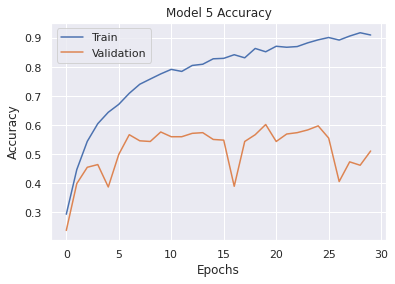

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])

plt.title('Model 5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.show()

In [ ]:
accuracy5 = model5.evaluate(X_test_dec_gb_norm, y_test_dec_gb_enc, verbose=2)

15/15 - 1s - loss: 2.1169 - accuracy: 0.5242 - 1s/epoch - 80ms/step


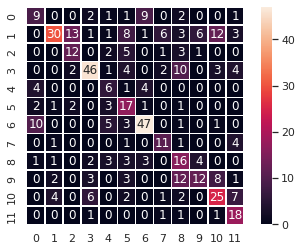

In [ ]:
y_pred = model5.predict(X_test_dec_gb_norm)

y_pred_max = np.argmax(y_pred, axis=1)
y_test_max = np.argmax(y_test_dec_gb_enc, axis=1)

cm = tf.math.confusion_matrix(y_pred_max, y_test_max)
sns.heatmap(cm,
            annot=True,
            fmt='d',
            linewidth=0.4,
            square=True)

In [ ]:
cf5 = classification_report(y_pred_max, y_test_max)
print(cf5)

              precision    recall  f1-score   support

           0       0.35      0.36      0.35        25
           1       0.77      0.36      0.49        84
           2       0.41      0.50      0.45        24
           3       0.75      0.64      0.69        72
           4       0.27      0.40      0.32        15
           5       0.35      0.63      0.45        27
           6       0.72      0.70      0.71        67
           7       0.50      0.61      0.55        18
           8       0.31      0.48      0.38        33
           9       0.52      0.29      0.38        41
          10       0.50      0.53      0.52        47
          11       0.47      0.82      0.60        22

    accuracy                           0.52       475
   macro avg       0.49      0.53      0.49       475
weighted avg       0.58      0.52      0.53       475



### Model 5 Insights
- Terrible results from VGG16, I had higher expectations as it only delivered a 52% test accuracy
- The latter might be caused by overfitting, as the model might be too complex for this task

# Model Comparison and Evaluation

## Accuracy and Loss Comparison

In [ ]:
print('Model1:', accuracy1)
print('Model2:', accuracy2)
print('Model3:', accuracy3)
print('Model4:', accuracy4)
print('Model5:', accuracy5)

Model1: [1.4899494647979736, 0.6189473867416382]
Model2: [1.1970860958099365, 0.6442105174064636]
Model3: [0.8870816230773926, 0.7200000286102295]
Model4: [0.9322496056556702, 0.785263180732727]
Model5: [2.1169323921203613, 0.524210512638092]


## Classification Report Comparison

In [ ]:
print('Model 1')
print(cf1)
print('Model 2')
print(cf2)
print('Model 3')
print(cf3)
print('Model 4')
print(cf4)
print('Model 5')
print(cf5)

Model 1
              precision    recall  f1-score   support

           0       0.19      0.56      0.29         9
           1       0.62      0.86      0.72        28
           2       0.41      0.48      0.44        25
           3       0.72      0.83      0.77        53
           4       0.23      0.31      0.26        16
           5       0.67      0.59      0.63        54
           6       0.89      0.55      0.68       106
           7       0.45      0.71      0.56        14
           8       0.65      0.64      0.65        53
           9       0.57      0.41      0.47        32
          10       0.86      0.69      0.77        62
          11       0.37      0.61      0.46        23

    accuracy                           0.62       475
   macro avg       0.55      0.60      0.56       475
weighted avg       0.68      0.62      0.63       475

Model 2
              precision    recall  f1-score   support

           0       0.08      0.25      0.12         8
        

## Best Model
- The best model that was trained is Model 4, as it achieved the highest test accuracy (78.5%) and the 2nd lowest loss (0.93). Model 4 has high success in recognizing most classes, as only 3 of them have an accuracy below 74%.
- Model 3 is a close runner up, as it had a good test accuracy too (72%) and had the lowest loss (0.88). There is a good argument to choose Model 3 over Model 4, and that is that Model 4 is overfitting but that was expected, as we added more complexity as we added more layers.

# Conclusions and Takeaways
- Model 4 is the best model and the one that should be used, for the reasons mentioned above.
- The only two flaws Model 4 has is that it is terrible at identifying class 0 and it is overfitting in some cases, so we must watch out for that.
- Reducing the size of the image and applying gaussian blur did have an important effect on the performance of the model, as we had a 3% and 11% increase from Model 1 with the same architecture and parameters, with resizing and then with resized and blurred images.
- The model had trouble recognizing some of the classes that had the fewest images, so data augmentation might be a tool that could help make our model more robust.